# Performance of Gibbs v.s. NUTS on MoGs

## 1. Load packages & helper functions

In [ ]:
# `Distributions.jl` is for distribution supports and `Turing.jl` is our PPL.
using Distributions, Turing

TPATH = Pkg.dir("Turing")

# `gmm.helper.jl` contains functions to build histogram plots
include(TPATH*"/example-models/nips-2017/gmm.helper.jl");

Function below takes $x$ from Gibbs and NUTS chains and make a histogram plot with exact density.

## 2. Defing the model

In [ ]:
@model GMM(p, μ, σ) = begin
  z ~ Categorical(p)
  x ~ Normal(μ[z], σ[z])
end

@model cGMM(p, μ, σ) = begin
  x ~ UnivariateGMM2(μ, σ, Categorical(p));
end

M = 5
p = [ 0.2,  0.2,   0.2, 0.2,  0.2]

s = [-0.5, -1.5, -0.75,  -2, -0.5]; σ = exp(s);

μ1 = [   0,    1,     2, 3.5, 4.25] + 2.5 * collect(0:4);
μ2 = [   0,    1,     2, 3.5, 4.25] + 0.5 * collect(0:4);

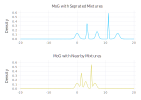

In [28]:
p1 = plot([make_norm_pdf(p, μ1, σ)], -20, 20, Theme(default_color=colors[1]), 
Guide.xlabel(nothing), Guide.ylabel("Density"), Guide.title("MoG with Seprated Mixtures"))
p2 = plot([make_norm_pdf(p, μ2, σ)], -20, 20, Theme(default_color=colors[2]),
Guide.xlabel(nothing), Guide.ylabel("Density"), Guide.title("MoG with Nearby Mixtures"))
vstack(p1, p2)

## 3. MCMC sampling

### Setting up the MCMC engines

In [3]:
N = 10000; K = 500;
gibbs = Gibbs(round(Int,N/K), PG(10, 1, :z), HMC(K-1, 0.2, 4, :x); thin=false)
nuts  = NUTS(N, 0.65);

### Sampling from MoG with seprated mixtures

In [ ]:
println("Running Gibbs")
chain_gibbs = sample(GMM(p, μ1, σ), gibbs)
x_gibbs = map(x_arr -> x_arr[1], chain_gibbs[:x]);

println("Running NUTS")
chain_nuts = sample(cGMM(p, μ1, σ), nuts)
x_nuts = map(x_arr -> x_arr[1], chain_nuts[:x]);

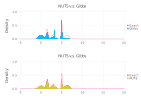

In [22]:
visualize(x_gibbs, x_nuts)

### Sampling from MoG with nearby mixtures

In [ ]:
println("Running Gibbs")
chain_gibbs = sample(GMM(p, μ2, σ), Gibbs(round(Int,N/K), PG(10, 1, :z), HMC(K-1, 0.2, 4, :x); thin=false))
x_gibbs = map(x_arr -> x_arr[1], chain_gibbs[:x]);

println("Running NUTS")
chain_nuts = sample(cGMM(p, μ2, σ), NUTS(N, 0.65))
x_nuts = map(x_arr -> x_arr[1], chain_nuts[:x]);

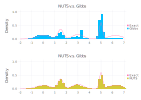

In [23]:
visualize(x_gibbs, x_nuts, -2, 7)